In [1]:
import identification as ob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import control as con
import warnings
import time
start_time = list(time.localtime())[5] 
#returns the local time at the start of execution. Can be used to calculate the execution time manually
%pylab inline
warnings.filterwarnings('ignore') 
#ignores all the warnings that may arise during runtime

/home/ipa325/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


###### Reading all the data

In [2]:
control_output_1 = 'data/2017-11-03_14-25-18_control_output.log'
task_velocity_1  = 'data/2017-11-03_14-25-19_task_vel.log'

control_output_2 = 'data/2017-11-03_14-26-43_control_output.log'
task_velocity_2  = 'data/2017-11-03_14-26-43_task_vel.log'

control_output_3 = 'data/2017-11-03_14-27-47_control_output.log'
task_velocity_3  = 'data/2017-11-03_14-27-47_task_vel.log'

control_output_4 = 'data/2017-11-03_14-30-43_control_output.log'
task_velocity_4  = 'data/2017-11-03_14-30-43_task_vel.log'

df_ist_soll_1 = ob.read_data(control_output_1, task_velocity_1)
df_ist_soll_2 = ob.read_data(control_output_2, task_velocity_2)
df_ist_soll_3 = ob.read_data(control_output_3, task_velocity_3)
df_ist_soll_4 = ob.read_data(control_output_4, task_velocity_4)

###### Removing all zeros & the negative trend and reformatting the data in accordance with a unit step response

In [3]:
#data3 is a data with a special case trend
df_ist_soll_3          = df_ist_soll_3[(df_ist_soll_3.x_ist > 0)]
#the following code identifies the decreasing trend in x_ist values and removes those values from the dataframe
df_ist_soll_3['trend'] = np.sign(df_ist_soll_3['x_ist'].rolling(window = 5).mean().diff().fillna(0)).map({0:'FLAT', 1:'UP', -1:'DOWN'})
reversed_array = list(df_ist_soll_3.trend.values)[::-1]
counter = 0
for i in range(0, len(reversed_array)):
    if reversed_array[i] == 'DOWN':
        counter = counter + 1
    else:
        break
length             = len(df_ist_soll_3)
df_ist_soll_3      = df_ist_soll_3.head(length - counter)


df_ist_soll_set = [df_ist_soll_1, df_ist_soll_2, df_ist_soll_3, df_ist_soll_4]
xin_array, yout_array, t_array = ob.strip_multiply(df_ist_soll_set)

###### Finding the fitted model and aic values using R 

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R 
library(stats) 
#for using the ar() function
library(forecast) 
#for using the fitted.values() function

In [6]:
#The function returns the aic,mse and fitted values for a given output data and a given order 
def order_ar_R(ar_order, output):
    %R -i ar_order,output 
    #data is inputed as a list vector. In a list vector, each element in the list is an array. No space can be provided after comma. If provided, it results in 'NameError: name '' is not defined' error.
    %R output                 = unlist(output)  
    #converts the list vector back into a single array. Need this step in latest R version 3.4.2.
    %R ar_system              = ar(output, method = "ols", order.max = ar_order)
    %R fitted_ar_with_missing = fitted.values(ar_system) 
    #the lower values in the output data contributes to NA/missing values in the fitted values. This corresponds to the delay in the output data.
    %R -o fitted_ar_with_missing
    
    fitted_ar_without_missing = np.nan_to_num(fitted_ar_with_missing) 
    #the missing values becomes nan values in Python and they are converted to 0. It becomes easier in finding the delay for our model.
    mse_ar = mean_squared_error(output,fitted_ar_without_missing)
        
    %R -i mse_ar
    %R output_length = length(output) 
    %R aic_ar        = (output_length * log(mse_ar)) + (2 * ar_order) + (output_length * dim(matrix(output))[2] * (log(2 * pi) + 1)) #result obtained from https://rdrr.io/cran/sysid/src/R/estpoly.R
    %R -o aic_ar,mse_ar
    
    return list(aic_ar), mse_ar, fitted_ar_without_missing

###### Finding the fitted model and aic values using Python 

In [7]:
order_ar_P = ob.order_ar_P

###### MSE and AIC Dataframe for orders 1 to 10 along with fitted values

In [8]:
#The function returns a dataframe that contains the aic,mse and order values from 1 to 10 along with the fitted values for each order 
def order_aic_mse_fit(yout):
    aic                  = []
    order                = []
    mse                  = []
    fit_values           = []
    aic_mse_fit_df       = [] 
    aic_mse_fit_df.append([])
    #2D array in which each element stores two floats(aic and mse) and an array(fit_values)
   
    for i in range(1,11):
        order.append(i)
        aic_mse_fit_df.append(order_ar_P(i,yout))
        aic.append(aic_mse_fit_df[i][0])
        mse.append(aic_mse_fit_df[i][1])
        fit_values.append(aic_mse_fit_df[i][2])
    
    df = pd.DataFrame(np.column_stack([order, aic, mse]),\
                      columns=['order', 'aic', 'mse']) 
    #all variables are passed into the dataframe as type float by default  
    return df, fit_values


df_fit_array = []
df_array = []
fit_val = []

for i in range(0, len(yout_array)):
    df_fit_array.append(order_aic_mse_fit(yout_array[i]))
    df_array.append(df_fit_array[i][0])
    fit_val.append(df_fit_array[i][1])

###### Selecting the best order and the corresponding aic, mse and fitted values for each data based on low mse value

In [9]:
#oma_best is an array that contains order, mse and aic values of the best fit data
oma_best    = []
mse_best    = []
aic_best    = []
order_best  = []
fitted_best = []

for i in range(0, len(df_fit_array)):
    oma_best.append(list(df_array[i][df_array[i].mse == df_array[i].mse.min()].values[0]))
    order_best.append(oma_best[i][0])
    mse_best.append(oma_best[i][1])
    aic_best.append(oma_best[i][2])    
    fitted_best.append(fit_val[i][int(order_best[i]) - 1])

###### Smoothing all the model outputs

In [10]:
smooth_1 = []
smooth_2 = []

for i in range(0, len(fitted_best)):
    smooth_1.append(ob.smooth(fitted_best[i], 1))
    smooth_2.append(ob.smooth(fitted_best[i], 2))

###### PT1 and PT2 Modeling on all data 

In [11]:
#youto,to are the yout and t outputs from the pt1 and pt2 system
#tf and delay are the transfer functions of the output and its delay
#tdytdts is an array that contains all the above values in a sequential order
to_1           = []
to_2           = []
tf_1           = []
tf_2           = []
zeta           = []
youto_1        = []
youto_2        = []
delay_1        = []
delay_2        = []
tdytdts_1      = []
tdytdts_2      = [] 
delay_tf_1     = []
delay_tf_2     = [] 
steady_state_1 = []
steady_state_2 = []
time_constant_1 = []
time_constant_2 = []

for i in range(0,len(smooth_1)):
    tdytdts_1.append(ob.pt1(smooth_1[i], t_array[i]))
    tf_1.append(tdytdts_1[i][0])
    youto_1.append(tdytdts_1[i][1])
    to_1.append(tdytdts_1[i][2])
    delay_1.append(tdytdts_1[i][3])
    time_constant_1.append(tdytdts_1[i][4])
    steady_state_1.append(tdytdts_1[i][5])
        
    tdytdts_2.append(ob.pt2(smooth_2[i], t_array[i]))
    tf_2.append(tdytdts_2[i][0])
    youto_2.append(tdytdts_2[i][1])
    to_2.append(tdytdts_2[i][2])
    delay_2.append(tdytdts_2[i][3])
    time_constant_2.append(tdytdts_2[i][4])
    steady_state_2.append(tdytdts_2[i][5])
    zeta.append(tdytdts_2[i][6])
    

###### Finding the best model in pt1 and pt2 

A = [[ -52.12875619 -459.87552219]
 [   1.            0.        ]]

B = [[ 1.]
 [ 0.]]

C = [[ -11.4400045   467.65720287]]

D = [[ 0.]]

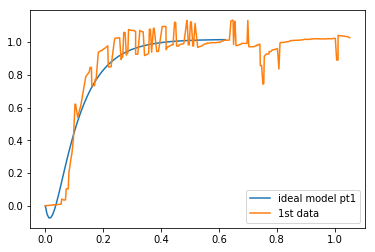

In [12]:
ideal_tf_pt1, ideal_model_output_pt1, ideal_model_time_pt1 = ob.ideal_pt1(steady_state_1, time_constant_1, delay_1)
plt.plot(ideal_model_time_pt1, ideal_model_output_pt1, label = 'ideal model pt1')
plt.plot(t_array[0], yout_array[0], label='1st data')
plt.legend()
ob.ss(ideal_tf_pt1)

A = [[ -5.99619038e+01  -9.34103083e+02  -6.29601494e+03]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00]]

B = [[ 1.]
 [ 0.]
 [ 0.]]

C = [[    0.          -157.07317837  6421.01174616]]

D = [[ 0.]]

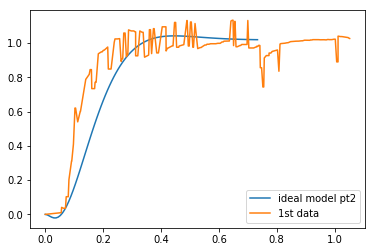

In [13]:
ideal_tf_pt2, ideal_model_output_pt2, ideal_model_time_pt2 = ob.ideal_pt2(steady_state_2, time_constant_2, delay_2, zeta)
plt.plot(ideal_model_time_pt2, ideal_model_output_pt2, label = 'ideal model pt2')
plt.plot(t_array[0], yout_array[0], label='1st data')
plt.legend()
ob.ss(ideal_tf_pt2)

In [14]:
end_time = list(time.localtime())[5]
s=np.subtract(end_time, start_time)
print('Total execution time is ',abs(s),' seconds')

Total execution time is  34  seconds
